## Handwritten Digit Classfication using Deep Feed Foward Neural Network

![model structure](tutorial_images/deep_feed_forward_NN/feedforwardNN_structure.png)

In [1]:
#import packages
import matplotlib
matplotlib.use('Agg')
%pylab inline
import pandas
import datetime as dt

from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *
from utils import get_mnist
import matplotlib.pyplot as plt
from pyspark import SparkContext
from matplotlib.pyplot import imshow
#Create spark context
sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","2g"))
init_engine()

Populating the interactive namespace from numpy and matplotlib
Prepending /home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path


In [2]:
# Get and store MNIST into RDD of Sample
mnist_path = "./data/mnist"
(train_data, test_data) = get_mnist(sc, mnist_path)

print(train_data.count())
print(test_data.count())

Extracting datasets/mnist/train-images-idx3-ubyte.gz
Extracting datasets/mnist/train-labels-idx1-ubyte.gz
Extracting datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting datasets/mnist/t10k-labels-idx1-ubyte.gz
60000
10000


In [5]:
#Declare basic parameters
learning_rate = 0.2
training_epochs = 15
batch_size = 2048
display_step = 1

# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [6]:
# Define Multilayer Perceptron with two hidden layer
def multilayer_perceptron(n_hidden_1, n_hidden_2, n_input, n_classes):
    # Initialize a sequential container
    model = Sequential()
    # Hidden layer with ReLu activation
    model.add(Reshape([28*28]))
    model.add(Linear(n_input, n_hidden_1).set_name('mlp_fc1'))
    model.add(ReLU())
    # Hidden layer with ReLu activation
    model.add(Linear(n_hidden_1, n_hidden_2).set_name('mlp_fc2'))
    model.add(ReLU())
    # output layer
    model.add(Linear(n_hidden_2, n_classes).set_name('mlp_fc3'))
    model.add(LogSoftMax())
    return model

In [7]:
#Create Model with two hidden layer and 10 classes
model = multilayer_perceptron(n_hidden_1, n_hidden_2, n_input, n_classes)

creating: createSequential
creating: createReshape
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createLogSoftMax


In [8]:
#Optimizer
# Create an Optimizer
optimizer = Optimizer(model=model,training_rdd=train_data,criterion=ClassNLLCriterion(),optim_method=SGD(learningrate=learning_rate),end_trigger=MaxEpoch(training_epochs),batch_size=batch_size)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createDistriOptimizer


In [9]:
# Set the validation logic
optimizer.set_validation(batch_size=batch_size,val_rdd=test_data,trigger=EveryEpoch(),val_method=[Top1Accuracy()])

creating: createEveryEpoch
creating: createTop1Accuracy


In [10]:
#Define App name
app_name='multilayer_perceptron-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
#Train summary
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',app_name=app_name)
#Set summary trigger
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
#Validation Summary
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',app_name=app_name)
#Set train summary
optimizer.set_train_summary(train_summary)
#Set validation summary
optimizer.set_val_summary(val_summary)
print("saving logs to ",app_name)

creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  multilayer_perceptron-20201216-131127


In [11]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")

Optimization Done.
CPU times: user 1.37 ms, sys: 2.85 ms, total: 4.21 ms
Wall time: 17.8 s


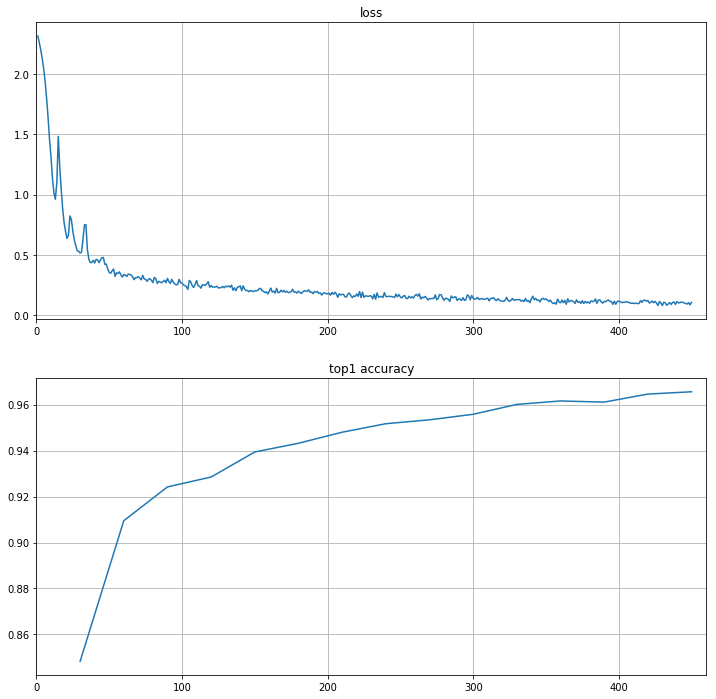

In [12]:
#Visualization for train_summary and val_summary
loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)

### Prediction on test data

In [13]:
#prediction results on test data by our trained model
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return int(l[0] - 1)

In [14]:
%%time
#Prediction on Test data
predictions = trained_model.predict(test_data)

CPU times: user 2.2 ms, sys: 1.28 ms, total: 3.48 ms
Wall time: 62.3 ms


Ground Truth labels:
7, 2, 1, 0, 4, 1, 4, 9
Predicted labels:
7, 2, 1, 0, 4, 1, 4, 9


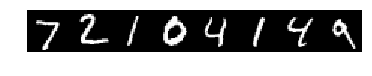

In [15]:
#plotting
imshow(np.column_stack([np.array(s.features[0].to_ndarray()).reshape(28,28) for s in test_data.take(8)]),cmap='gray'); plt.axis('off')
print('Ground Truth labels:')
print(', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(8)))
print('Predicted labels:')
print(', '.join(str(map_predict_label(s)) for s in predictions.take(8)))